In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import os
import random
import cv2
import ultralytics

import tensorflow as tf
from ultralytics import YOLO
from PIL import Image
import yaml
from collections import defaultdict

import albumentations as A
import shutil
from tqdm import tqdm

In [2]:
import torch

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
dir = "G:/My Drive/UAO/7° Semestre/IA Embebidos/proyecto_3/Trash"

In [5]:
with open(os.path.join(dir, "data.yaml"), 'r') as f:
  data_yaml = yaml.safe_load(f)
  class_names = data_yaml['names']
  num_classes = len(class_names)

In [6]:
print(class_names)
print(num_classes)

['Bateria', 'BotellaPlastico', 'BotellaVidrio', 'HojaPapel', 'TapaPlastico', 'TazaPapel']
6


## Lectura y validación de imágenes con su máscara 

In [8]:
def show_image_with_boxes(img_path, label_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  h, w = img.shape[:2]

  fig, ax = plt.subplots(1)
  ax.imshow(img)

  with open(label_path, 'r') as f:
    for line in f.readlines():
      cls_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
      x_center *= w
      y_center *= h
      box_w *= w
      box_h *= h
      x1 = x_center - box_w / 2
      y1 = y_center - box_h / 2
      rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                                edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      ax.text(x1, y1 - 10, class_names[int(cls_id)],
              color='white', backgroundcolor='red', fontsize=8)
  plt.axis('off')
  plt.show()

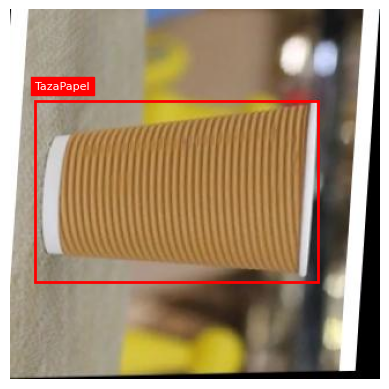

In [9]:
subsets = ['train', 'valid', 'test']

subset = subsets[0]
images_dir = os.path.join(dir, subset, 'images')
labels_dir = os.path.join(dir, subset, 'labels')

random_image = random.choice(os.listdir(images_dir))
img_path = os.path.join(images_dir, random_image)
label_path = os.path.join(labels_dir, random_image.replace('.jpg', '.txt').replace('.png', '.txt'))

show_image_with_boxes(img_path, label_path)

In [11]:
def count_boxes_per_class(base_path, sets):
  stats = {}

  for s in sets:
    labels_dir = os.path.join(base_path, s, 'labels')
    class_counts = defaultdict(int)

    for label_file in os.listdir(labels_dir):
      with open(os.path.join(labels_dir, label_file), 'r') as f:
        for line in f:
          cls_id = int(float(line.strip().split()[0]))
          class_counts[cls_id] += 1

    stats[s] = {class_names[k]: v for k, v in class_counts.items()}
  return stats

## Entrenamiento de modelo

In [12]:
model = YOLO('yolov8n.pt')

In [13]:
model.train(
  data= dir + '/data.yaml',
  epochs=150,
  imgsz=320,
  batch=16,
  workers=2,
  name='trash_yolov8n_v3',
  device=0  # Usa 'cpu' o '0' para GPU
)

New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=G:/My Drive/UAO/7 Semestre/IA Embebidos/proyecto_3/Trash/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=Fals

train: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\train\labels.cache... 3626 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3626/3626 [00:00<?, ?it/s]

train: G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\train\images\test_Image_93_png.rf.10b0834330bfef3664d379044b1383e2.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 1.30.2 ms, read: 0.60.2 MB/s, size: 13.3 KB)


val: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\valid\labels.cache... 1033 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1033/1033 [00:00<?, ?it/s]


Plotting labels to runs\detect\trash_yolov8n_v3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs\detect\trash_yolov8n_v3
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150     0.811G      1.313      2.552      1.275         78        320: 100%|██████████| 227/227 [00:49<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.39it/s]


                   all       1033       3922      0.625      0.485      0.533      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150     0.916G      1.306      1.718      1.271         57        320: 100%|██████████| 227/227 [00:32<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.79it/s]


                   all       1033       3922      0.573       0.46      0.494      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150     0.916G      1.315      1.624      1.272         97        320: 100%|██████████| 227/227 [00:32<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.33it/s]


                   all       1033       3922       0.67      0.518      0.578      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150     0.916G      1.316       1.58       1.27         79        320: 100%|██████████| 227/227 [00:33<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.19it/s]


                   all       1033       3922      0.569      0.485      0.518      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150     0.918G      1.302      1.499      1.271         45        320: 100%|██████████| 227/227 [00:32<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.26it/s]


                   all       1033       3922      0.676      0.571      0.642      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150     0.918G      1.259      1.389      1.242         49        320: 100%|██████████| 227/227 [00:35<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.37it/s]


                   all       1033       3922      0.664      0.585      0.601      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150     0.918G      1.246      1.364      1.233         70        320: 100%|██████████| 227/227 [00:33<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.56it/s]


                   all       1033       3922      0.708      0.616      0.674      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150     0.918G      1.229      1.296       1.23        118        320: 100%|██████████| 227/227 [00:35<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.30it/s]


                   all       1033       3922      0.713       0.57      0.631      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150     0.918G      1.215      1.255      1.216         84        320: 100%|██████████| 227/227 [00:32<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.40it/s]


                   all       1033       3922       0.75      0.655      0.729      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150     0.918G      1.192      1.209      1.209         35        320: 100%|██████████| 227/227 [00:33<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.49it/s]


                   all       1033       3922      0.724      0.665      0.733      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150     0.918G      1.186      1.163      1.205         50        320: 100%|██████████| 227/227 [00:34<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.49it/s]


                   all       1033       3922      0.758      0.684      0.754      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150     0.918G      1.168      1.131      1.191         53        320: 100%|██████████| 227/227 [00:38<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.65it/s]

                   all       1033       3922       0.74      0.673      0.716      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150     0.918G      1.164      1.116      1.187         62        320: 100%|██████████| 227/227 [00:25<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.63it/s]

                   all       1033       3922      0.784      0.647      0.721      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150     0.918G      1.162      1.097      1.185         82        320: 100%|██████████| 227/227 [00:25<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.70it/s]

                   all       1033       3922      0.767      0.685       0.74      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150     0.918G       1.14      1.075      1.177         51        320: 100%|██████████| 227/227 [00:28<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.33it/s]

                   all       1033       3922       0.81      0.674      0.777      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150     0.918G      1.134      1.058      1.179         76        320: 100%|██████████| 227/227 [00:37<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.17it/s]

                   all       1033       3922      0.795      0.731      0.809       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150     0.918G      1.159      1.067      1.182         60        320: 100%|██████████| 227/227 [00:25<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.52it/s]

                   all       1033       3922      0.823      0.729      0.817      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150     0.918G      1.125      1.012      1.169         55        320: 100%|██████████| 227/227 [00:26<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.23it/s]

                   all       1033       3922      0.784      0.748      0.814      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150     0.918G      1.125      1.004      1.166        114        320: 100%|██████████| 227/227 [00:24<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]

                   all       1033       3922      0.821      0.739      0.826      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150     0.918G      1.099     0.9714      1.156         75        320: 100%|██████████| 227/227 [00:24<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.98it/s]

                   all       1033       3922      0.813      0.749       0.82      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150     0.918G      1.102     0.9508      1.153         93        320: 100%|██████████| 227/227 [00:23<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.88it/s]

                   all       1033       3922      0.816      0.766      0.838      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150     0.918G      1.083     0.9374      1.147         61        320: 100%|██████████| 227/227 [00:23<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.27it/s]

                   all       1033       3922      0.791       0.73      0.799      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150     0.918G      1.091     0.9292      1.145         76        320: 100%|██████████| 227/227 [00:24<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.81it/s]

                   all       1033       3922      0.841       0.76      0.834      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150     0.918G       1.08     0.9248      1.145         42        320: 100%|██████████| 227/227 [00:25<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.80it/s]

                   all       1033       3922      0.816      0.744      0.827      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150     0.918G      1.087     0.9212      1.148         42        320: 100%|██████████| 227/227 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.04it/s]

                   all       1033       3922      0.825       0.74      0.822      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150     0.918G      1.071     0.9053      1.141         48        320: 100%|██████████| 227/227 [00:22<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]

                   all       1033       3922      0.817      0.789      0.841      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150     0.918G       1.07     0.8965      1.144         47        320: 100%|██████████| 227/227 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.95it/s]

                   all       1033       3922      0.823      0.759      0.842      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150     0.918G      1.059     0.8729      1.129         51        320: 100%|██████████| 227/227 [00:23<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]

                   all       1033       3922      0.829       0.78      0.846      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150     0.918G      1.057     0.8628      1.134         57        320: 100%|██████████| 227/227 [00:23<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.01it/s]

                   all       1033       3922      0.831      0.759      0.832      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150     0.918G      1.054      0.874      1.126         53        320: 100%|██████████| 227/227 [00:23<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.55it/s]

                   all       1033       3922      0.797      0.775      0.831      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150     0.918G      1.057     0.8561       1.13         59        320: 100%|██████████| 227/227 [00:23<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.75it/s]

                   all       1033       3922      0.843      0.787      0.863      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150     0.918G      1.039     0.8449      1.126        132        320: 100%|██████████| 227/227 [00:23<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.33it/s]

                   all       1033       3922      0.842      0.754      0.837      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150     0.918G      1.039     0.8525      1.126         76        320: 100%|██████████| 227/227 [00:24<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.90it/s]

                   all       1033       3922      0.863      0.777      0.869      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150     0.918G      1.043     0.8367      1.116         74        320: 100%|██████████| 227/227 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.90it/s]

                   all       1033       3922      0.839      0.782      0.862      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150     0.918G      1.036     0.8367      1.121         55        320: 100%|██████████| 227/227 [00:24<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]

                   all       1033       3922      0.855      0.794       0.87      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150     0.918G      1.042     0.8315      1.119         45        320: 100%|██████████| 227/227 [00:24<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.05it/s]

                   all       1033       3922      0.858      0.797       0.87      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150     0.918G      1.005     0.7889      1.109         77        320: 100%|██████████| 227/227 [00:25<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.58it/s]

                   all       1033       3922       0.86      0.778      0.864      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150     0.918G       1.03     0.8037      1.116         45        320: 100%|██████████| 227/227 [00:23<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.71it/s]

                   all       1033       3922      0.836      0.796      0.859      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150     0.918G      1.037     0.8184      1.126         40        320: 100%|██████████| 227/227 [00:23<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.23it/s]

                   all       1033       3922      0.855       0.78      0.864      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150     0.918G      1.018     0.7771      1.109         65        320: 100%|██████████| 227/227 [00:23<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.15it/s]

                   all       1033       3922      0.868      0.794       0.87      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150     0.918G      1.026     0.7824      1.113         60        320: 100%|██████████| 227/227 [00:22<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.85it/s]

                   all       1033       3922      0.888      0.779       0.87      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150     0.918G      1.017     0.7842      1.108         56        320: 100%|██████████| 227/227 [00:24<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.36it/s]

                   all       1033       3922      0.869      0.781      0.867      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150     0.918G      1.004     0.7725      1.099         68        320: 100%|██████████| 227/227 [00:22<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.06it/s]

                   all       1033       3922      0.896      0.778       0.87      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150     0.918G      1.016     0.7637      1.108         65        320: 100%|██████████| 227/227 [00:23<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.69it/s]

                   all       1033       3922      0.888      0.787      0.872      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150     0.918G      1.001     0.7746      1.099         47        320: 100%|██████████| 227/227 [00:23<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.22it/s]

                   all       1033       3922      0.861      0.812      0.879      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150     0.918G     0.9899     0.7539      1.093         45        320: 100%|██████████| 227/227 [00:23<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.88it/s]

                   all       1033       3922      0.885        0.8      0.883      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150     0.918G     0.9836     0.7551      1.098         88        320: 100%|██████████| 227/227 [00:23<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.93it/s]

                   all       1033       3922      0.864       0.81      0.875      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150     0.918G     0.9997     0.7655      1.099         79        320: 100%|██████████| 227/227 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]

                   all       1033       3922      0.877      0.809      0.886      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150     0.918G      1.001     0.7419      1.098        101        320: 100%|██████████| 227/227 [00:23<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.27it/s]

                   all       1033       3922      0.866      0.795      0.878      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150     0.918G     0.9922      0.736      1.089         64        320: 100%|██████████| 227/227 [00:22<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.07it/s]

                   all       1033       3922      0.871      0.802      0.874      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150     0.918G     0.9801     0.7464       1.09         46        320: 100%|██████████| 227/227 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]

                   all       1033       3922      0.863      0.795       0.87      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150     0.918G     0.9769     0.7315      1.088         28        320: 100%|██████████| 227/227 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.18it/s]

                   all       1033       3922      0.874      0.811       0.88      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150     0.918G      0.991     0.7273      1.095         55        320: 100%|██████████| 227/227 [00:30<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.97it/s]

                   all       1033       3922      0.877      0.813      0.888      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150     0.918G       0.98     0.7246      1.087         56        320: 100%|██████████| 227/227 [00:23<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.93it/s]

                   all       1033       3922      0.882      0.819      0.887      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150     0.918G     0.9736     0.7223      1.085         54        320: 100%|██████████| 227/227 [00:23<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.04it/s]

                   all       1033       3922      0.888      0.825      0.896      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150     0.918G     0.9793     0.7123      1.088        103        320: 100%|██████████| 227/227 [00:22<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.04it/s]

                   all       1033       3922      0.887      0.821      0.898      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150     0.918G     0.9639     0.7068      1.081         83        320: 100%|██████████| 227/227 [00:22<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.62it/s]

                   all       1033       3922      0.899      0.805      0.894      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150     0.918G     0.9736     0.7092      1.086         37        320: 100%|██████████| 227/227 [00:23<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.21it/s]

                   all       1033       3922      0.883      0.801      0.885      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150     0.918G     0.9599     0.6961      1.076         74        320: 100%|██████████| 227/227 [00:22<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.92it/s]

                   all       1033       3922        0.9      0.792      0.879      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150     0.918G     0.9662     0.6953      1.081         50        320: 100%|██████████| 227/227 [00:22<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.81it/s]

                   all       1033       3922      0.904        0.8      0.888      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150     0.918G     0.9484     0.6909      1.078         36        320: 100%|██████████| 227/227 [00:22<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.96it/s]

                   all       1033       3922      0.894      0.806       0.89       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150     0.918G     0.9457     0.6907      1.072         49        320: 100%|██████████| 227/227 [00:23<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.43it/s]

                   all       1033       3922      0.875      0.833        0.9      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150     0.918G     0.9486     0.6919      1.074         54        320: 100%|██████████| 227/227 [00:22<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.90it/s]

                   all       1033       3922      0.889      0.817      0.896      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150     0.918G     0.9519     0.6853      1.074         54        320: 100%|██████████| 227/227 [00:22<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.87it/s]

                   all       1033       3922      0.899        0.8      0.888       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150     0.918G     0.9543      0.689      1.077         40        320: 100%|██████████| 227/227 [00:22<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.39it/s]

                   all       1033       3922      0.895      0.803      0.889      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150     0.918G     0.9348     0.6771      1.072         55        320: 100%|██████████| 227/227 [00:22<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.95it/s]

                   all       1033       3922      0.882      0.806      0.888      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150     0.918G      0.941      0.679      1.068         95        320: 100%|██████████| 227/227 [00:23<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.82it/s]

                   all       1033       3922       0.88      0.834      0.893      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150     0.918G     0.9411     0.6769      1.068        160        320: 100%|██████████| 227/227 [00:23<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.22it/s]

                   all       1033       3922      0.873      0.842      0.906       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150     0.918G     0.9322     0.6618      1.069         83        320: 100%|██████████| 227/227 [00:23<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.82it/s]

                   all       1033       3922      0.893      0.832      0.906      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150     0.918G     0.9359     0.6697      1.068         83        320: 100%|██████████| 227/227 [00:23<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.53it/s]

                   all       1033       3922      0.879       0.84      0.899       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150     0.918G      0.936     0.6621      1.066         31        320: 100%|██████████| 227/227 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.07it/s]

                   all       1033       3922       0.89      0.823      0.897      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150     0.918G     0.9375     0.6615      1.063        116        320: 100%|██████████| 227/227 [00:24<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.82it/s]

                   all       1033       3922      0.901      0.808      0.897      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150     0.918G     0.9351     0.6625      1.068         44        320: 100%|██████████| 227/227 [00:24<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.59it/s]

                   all       1033       3922      0.894      0.826      0.905      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150     0.918G     0.9305       0.65       1.06         35        320: 100%|██████████| 227/227 [00:26<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.45it/s]

                   all       1033       3922      0.911      0.807      0.894      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150     0.918G       0.93     0.6514      1.058         39        320: 100%|██████████| 227/227 [00:25<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.46it/s]

                   all       1033       3922      0.896      0.834      0.901      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150     0.918G     0.9157     0.6426      1.056         45        320: 100%|██████████| 227/227 [00:25<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.90it/s]

                   all       1033       3922      0.894      0.837      0.907      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150     0.918G     0.9234     0.6418      1.062         65        320: 100%|██████████| 227/227 [00:24<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.36it/s]

                   all       1033       3922       0.89      0.856      0.912      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150     0.918G     0.9203      0.635      1.057         60        320: 100%|██████████| 227/227 [00:24<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.74it/s]

                   all       1033       3922      0.896      0.843      0.907      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150     0.918G     0.9057     0.6342      1.057         83        320: 100%|██████████| 227/227 [00:24<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.66it/s]

                   all       1033       3922      0.879       0.85      0.911       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150     0.918G     0.9158     0.6493      1.059         60        320: 100%|██████████| 227/227 [00:24<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.51it/s]

                   all       1033       3922      0.896      0.826      0.904       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150     0.918G     0.9105     0.6295      1.057         65        320: 100%|██████████| 227/227 [00:29<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.32it/s]

                   all       1033       3922      0.899      0.832      0.906       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150     0.918G     0.8985     0.6298      1.049        132        320: 100%|██████████| 227/227 [00:26<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s]

                   all       1033       3922      0.899      0.833       0.91      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150     0.918G     0.9015     0.6246      1.051         42        320: 100%|██████████| 227/227 [00:26<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.63it/s]

                   all       1033       3922      0.897      0.826      0.902      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150     0.918G     0.9007     0.6247      1.047         36        320: 100%|██████████| 227/227 [00:27<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s]

                   all       1033       3922       0.88       0.85       0.91      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150     0.918G     0.9111     0.6239      1.051         62        320: 100%|██████████| 227/227 [00:27<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.40it/s]

                   all       1033       3922      0.912      0.822      0.908      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150     0.918G     0.9046     0.6193       1.05         52        320: 100%|██████████| 227/227 [00:27<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.25it/s]

                   all       1033       3922      0.913      0.826      0.908       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150     0.918G     0.8959     0.6148      1.047         45        320: 100%|██████████| 227/227 [00:25<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.56it/s]

                   all       1033       3922      0.897      0.839      0.902       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150     0.918G     0.8928     0.6104      1.044         64        320: 100%|██████████| 227/227 [00:28<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s]

                   all       1033       3922      0.904      0.828      0.901      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150     0.918G      0.899     0.6099      1.047         33        320: 100%|██████████| 227/227 [00:25<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.82it/s]

                   all       1033       3922      0.903       0.83      0.905      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150     0.918G     0.8849      0.602      1.043         74        320: 100%|██████████| 227/227 [00:25<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.58it/s]

                   all       1033       3922      0.891      0.845        0.9      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150     0.918G     0.9066     0.6203      1.048         54        320: 100%|██████████| 227/227 [00:30<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.70it/s]

                   all       1033       3922      0.898      0.839      0.901      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150     0.918G     0.8882     0.6063       1.04         78        320: 100%|██████████| 227/227 [00:28<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.53it/s]

                   all       1033       3922      0.894      0.842      0.909      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150     0.918G     0.8731     0.5952      1.041         48        320: 100%|██████████| 227/227 [00:28<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.66it/s]

                   all       1033       3922      0.915      0.815      0.893      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150     0.918G     0.8896     0.6011      1.046         70        320: 100%|██████████| 227/227 [00:26<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.40it/s]

                   all       1033       3922      0.914      0.826      0.906      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150     0.918G     0.8754     0.5894      1.033         53        320: 100%|██████████| 227/227 [00:26<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.62it/s]

                   all       1033       3922      0.908      0.827      0.903      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150     0.918G     0.8753     0.5882      1.032         65        320: 100%|██████████| 227/227 [00:25<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.49it/s]

                   all       1033       3922      0.917      0.818      0.902      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150     0.918G     0.8749     0.5921      1.035         54        320: 100%|██████████| 227/227 [00:24<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.70it/s]

                   all       1033       3922      0.912      0.827      0.905      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150     0.918G     0.8898     0.5976      1.039         31        320: 100%|██████████| 227/227 [00:25<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.59it/s]

                   all       1033       3922      0.885      0.854      0.911      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150     0.918G     0.8642     0.5816      1.036         78        320: 100%|██████████| 227/227 [00:25<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.43it/s]

                   all       1033       3922      0.912      0.824      0.906      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150     0.918G     0.8699      0.583      1.034         35        320: 100%|██████████| 227/227 [00:25<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.61it/s]

                   all       1033       3922       0.91      0.827      0.903      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150     0.918G      0.869     0.5894      1.034         60        320: 100%|██████████| 227/227 [00:25<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.73it/s]

                   all       1033       3922      0.902      0.825        0.9      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150     0.918G     0.8731     0.5816      1.038        134        320: 100%|██████████| 227/227 [00:24<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.70it/s]

                   all       1033       3922      0.913      0.827      0.908      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150     0.918G     0.8604     0.5741      1.033         57        320: 100%|██████████| 227/227 [00:25<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.64it/s]

                   all       1033       3922      0.906      0.841      0.912      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150     0.918G     0.8635     0.5708      1.034         46        320: 100%|██████████| 227/227 [00:24<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.65it/s]

                   all       1033       3922      0.893       0.85      0.911      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150     0.918G     0.8624     0.5722       1.03        110        320: 100%|██████████| 227/227 [00:25<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.48it/s]

                   all       1033       3922      0.911      0.831      0.903      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150     0.918G     0.8529     0.5709      1.028         51        320: 100%|██████████| 227/227 [00:25<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.60it/s]

                   all       1033       3922      0.882      0.852      0.907       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150     0.918G     0.8594     0.5717      1.027         44        320: 100%|██████████| 227/227 [00:26<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.56it/s]

                   all       1033       3922      0.908      0.838      0.905      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150     0.918G     0.8536     0.5704      1.025         34        320: 100%|██████████| 227/227 [00:25<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.66it/s]

                   all       1033       3922      0.911      0.838      0.905      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150     0.918G     0.8574     0.5709      1.028        101        320: 100%|██████████| 227/227 [00:26<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.59it/s]

                   all       1033       3922      0.899      0.852      0.912      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150     0.918G     0.8658     0.5673      1.028         62        320: 100%|██████████| 227/227 [00:25<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.60it/s]

                   all       1033       3922      0.913      0.838      0.912      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150     0.918G     0.8515      0.559      1.024         47        320: 100%|██████████| 227/227 [00:25<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s]

                   all       1033       3922      0.924      0.833      0.908      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150     0.918G       0.84     0.5551       1.02         47        320: 100%|██████████| 227/227 [00:26<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.63it/s]

                   all       1033       3922      0.913       0.84      0.911      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150     0.918G     0.8364     0.5569      1.023         80        320: 100%|██████████| 227/227 [00:28<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.37it/s]

                   all       1033       3922      0.916      0.833      0.902      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150     0.918G     0.8449     0.5558      1.021         41        320: 100%|██████████| 227/227 [00:30<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.36it/s]

                   all       1033       3922      0.907      0.842      0.907      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150     0.918G      0.843     0.5481      1.016         65        320: 100%|██████████| 227/227 [00:29<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.64it/s]

                   all       1033       3922      0.917      0.831      0.906      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150     0.918G     0.8404     0.5539      1.016         77        320: 100%|██████████| 227/227 [00:29<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.65it/s]

                   all       1033       3922      0.906      0.838      0.904      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150     0.918G     0.8388     0.5514      1.021         62        320: 100%|██████████| 227/227 [00:30<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.43it/s]

                   all       1033       3922      0.908      0.845      0.912      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150     0.918G     0.8369     0.5518      1.017         46        320: 100%|██████████| 227/227 [00:29<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.48it/s]

                   all       1033       3922      0.906      0.845      0.909      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150     0.918G     0.8394     0.5497       1.02         57        320: 100%|██████████| 227/227 [00:30<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.49it/s]

                   all       1033       3922      0.908      0.838      0.906      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150     0.918G     0.8374     0.5463      1.019         46        320: 100%|██████████| 227/227 [00:29<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.65it/s]

                   all       1033       3922      0.913      0.832        0.9      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150     0.918G     0.8341     0.5371      1.011         80        320: 100%|██████████| 227/227 [00:30<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.57it/s]

                   all       1033       3922      0.922      0.832      0.905      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150     0.918G     0.8133     0.5305      1.012         54        320: 100%|██████████| 227/227 [00:31<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.47it/s]

                   all       1033       3922      0.917      0.834      0.904      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150     0.918G      0.828     0.5368      1.015         63        320: 100%|██████████| 227/227 [00:31<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.53it/s]

                   all       1033       3922      0.906       0.85      0.913      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150     0.918G      0.839     0.5452      1.015         59        320: 100%|██████████| 227/227 [00:30<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.63it/s]

                   all       1033       3922      0.922      0.837      0.912      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150     0.918G     0.8328     0.5384      1.018         60        320: 100%|██████████| 227/227 [00:29<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.47it/s]

                   all       1033       3922      0.912      0.841      0.905      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150     0.918G     0.8164     0.5301      1.013         34        320: 100%|██████████| 227/227 [00:29<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.57it/s]

                   all       1033       3922      0.914       0.84      0.907      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150     0.918G     0.8236     0.5335      1.013         54        320: 100%|██████████| 227/227 [00:29<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.63it/s]

                   all       1033       3922      0.921      0.841      0.911      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150     0.918G     0.8183     0.5325      1.014         58        320: 100%|██████████| 227/227 [00:29<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.48it/s]

                   all       1033       3922      0.925      0.836      0.912      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150     0.918G     0.8187     0.5333      1.012         55        320: 100%|██████████| 227/227 [00:30<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.48it/s]

                   all       1033       3922      0.921      0.835      0.902      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150     0.918G     0.8163     0.5327      1.009         86        320: 100%|██████████| 227/227 [00:29<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.51it/s]

                   all       1033       3922      0.922      0.833      0.901      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150     0.918G     0.8145     0.5249      1.012         41        320: 100%|██████████| 227/227 [00:29<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.57it/s]

                   all       1033       3922      0.913      0.837      0.903      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150     0.918G     0.8154     0.5222      1.009         67        320: 100%|██████████| 227/227 [00:29<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.59it/s]

                   all       1033       3922      0.913       0.84      0.908      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150     0.918G      0.807     0.5198      1.011         84        320: 100%|██████████| 227/227 [00:28<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.58it/s]

                   all       1033       3922      0.923      0.835      0.909      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150     0.918G     0.8107     0.5192      1.011         33        320: 100%|██████████| 227/227 [00:29<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.53it/s]

                   all       1033       3922      0.917      0.837      0.907      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150     0.918G     0.8061     0.5193      1.004         98        320: 100%|██████████| 227/227 [00:29<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.55it/s]

                   all       1033       3922      0.919      0.839      0.903      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150     0.918G     0.8117     0.5239      1.008         52        320: 100%|██████████| 227/227 [00:28<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.54it/s]

                   all       1033       3922      0.923      0.833      0.905      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150     0.918G     0.7986     0.5109      1.005         41        320: 100%|██████████| 227/227 [00:29<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.62it/s]

                   all       1033       3922      0.923      0.831      0.906      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150     0.918G     0.7997     0.5168      1.004         43        320: 100%|██████████| 227/227 [00:29<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.58it/s]

                   all       1033       3922      0.918      0.833      0.906      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150     0.918G     0.8078     0.5232       1.01         44        320: 100%|██████████| 227/227 [00:29<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.56it/s]

                   all       1033       3922      0.915      0.839      0.907      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150     0.918G     0.7955     0.5116      1.006        109        320: 100%|██████████| 227/227 [00:28<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.55it/s]

                   all       1033       3922      0.922      0.834      0.905      0.686


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150     0.918G     0.7224      0.429     0.9442         18        320: 100%|██████████| 227/227 [00:29<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.59it/s]

                   all       1033       3922      0.922      0.832      0.908      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150     0.918G      0.719     0.4236      0.945         51        320: 100%|██████████| 227/227 [00:29<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.50it/s]

                   all       1033       3922      0.926       0.83      0.906      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150     0.918G      0.708     0.4116      0.938         34        320: 100%|██████████| 227/227 [00:28<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.50it/s]

                   all       1033       3922       0.91      0.836      0.901      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150     0.918G     0.7157     0.4173     0.9397         29        320: 100%|██████████| 227/227 [00:29<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.71it/s]

                   all       1033       3922      0.926      0.827      0.902      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150     0.918G     0.7116      0.409       0.94         18        320: 100%|██████████| 227/227 [00:29<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.50it/s]

                   all       1033       3922      0.928      0.828      0.901      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150     0.918G     0.7015     0.4097     0.9321         37        320: 100%|██████████| 227/227 [00:28<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.53it/s]

                   all       1033       3922      0.915      0.834      0.903      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150     0.918G     0.6987     0.4056     0.9309         18        320: 100%|██████████| 227/227 [00:28<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.46it/s]

                   all       1033       3922      0.918      0.835      0.906      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150     0.918G     0.7032     0.4065     0.9346         41        320: 100%|██████████| 227/227 [00:28<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.36it/s]

                   all       1033       3922      0.919      0.835      0.906      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150     0.918G     0.6931     0.3976     0.9308         26        320: 100%|██████████| 227/227 [00:29<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.49it/s]

                   all       1033       3922      0.914      0.839      0.907      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150     0.918G     0.6907     0.4029     0.9317         24        320: 100%|██████████| 227/227 [00:29<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.51it/s]

                   all       1033       3922      0.913       0.84      0.907      0.688



150 epochs completed in 1.399 hours.
Optimizer stripped from runs\detect\trash_yolov8n_v3\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\trash_yolov8n_v3\weights\best.pt, 6.2MB

Validating runs\detect\trash_yolov8n_v3\weights\best.pt...
Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.41it/s]


                   all       1033       3922      0.925      0.836      0.911      0.689
               Bateria        152        595      0.968      0.956       0.98      0.778
       BotellaPlastico        166        600      0.928      0.861      0.919      0.718
         BotellaVidrio        219        758      0.921      0.909      0.952      0.781
             HojaPapel        409        706       0.96      0.841      0.948      0.742
          TapaPlastico        186        660      0.894       0.82      0.861      0.567
             TazaPapel         87        603      0.877      0.628      0.808       0.55
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs\detect\trash_yolov8n_v3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002012FF9C310>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

In [14]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.90.2 ms, read: 2.51.3 MB/s, size: 18.5 KB)


val: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\valid\labels.cache... 1033 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1033/1033 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:08<00:00,  7.28it/s]


                   all       1033       3922      0.927      0.834      0.911      0.689
               Bateria        152        595      0.968      0.956       0.98      0.779
       BotellaPlastico        166        600      0.928       0.86      0.919      0.718
         BotellaVidrio        219        758      0.923      0.909      0.952      0.781
             HojaPapel        409        706      0.962      0.841      0.946       0.74
          TapaPlastico        186        660      0.898      0.815      0.863      0.568
             TazaPapel         87        603       0.88      0.625      0.806      0.549
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\trash_yolov8n_v32
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002012DCC50C0>
curves: 

In [ ]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.90.1 ms, read: 2.71.3 MB/s, size: 18.5 KB)


val: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\valid\labels.cache... 1033 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1033/1033 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.76it/s]


                   all       1033       3922      0.915       0.84      0.905      0.696
               Bateria        152        595      0.984      0.955      0.976      0.788
       BotellaPlastico        166        600      0.905      0.871      0.913       0.72
         BotellaVidrio        219        758       0.92      0.915      0.954      0.789
             HojaPapel        409        706      0.952      0.861      0.946      0.751
          TapaPlastico        186        660      0.878      0.803       0.86      0.583
             TazaPapel         87        603       0.85      0.637      0.784      0.543
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\trash_yolov8n2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000225F4A33790>
curves: ['P

In [15]:
model.save("Model/modelo_yolov8n_v3.pt")

In [16]:
results = model.val(
  data=dir + "/data.yaml",
  split='test',
  imgsz=320,
  batch=16,
  project=dir + '/resultados',
  name='val_yolov8n_v3',
  exist_ok=True
)

Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
val: Fast image access  (ping: 0.90.1 ms, read: 1.10.6 MB/s, size: 12.1 KB)


val: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\test\labels.cache... 525 images, 0 backgrounds, 0 corrupt: 100%|██████████| 525/525 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]


                   all        525       1802      0.921      0.877      0.926      0.716
               Bateria         78        395      0.979      0.822      0.914      0.715
       BotellaPlastico         82        257      0.899      0.903      0.947      0.759
         BotellaVidrio        111        269      0.915      0.921      0.961      0.839
             HojaPapel        207        294      0.976      0.981      0.994      0.828
          TapaPlastico         84        261      0.902      0.878      0.929      0.646
             TazaPapel         45        326      0.856      0.755      0.811      0.511
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\resultados\val_yolov8n_v3


In [ ]:
results = model.val(
  data=dir + "/data.yaml",
  split='test',
  imgsz=320,
  batch=16,
  project=dir + '/resultados',
  name='val_yolov8n_v3',
  exist_ok=True
)

Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
val: Fast image access  (ping: 0.80.1 ms, read: 1.20.5 MB/s, size: 12.1 KB)


val: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\test\labels... 525 images, 0 backgrounds, 0 corrupt: 100%|██████████| 525/525 [00:23<00:00, 21.97it/s]


val: New cache created: G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  4.27it/s]


                   all        525       1802      0.938       0.86      0.916      0.716
               Bateria         78        395      0.997      0.795      0.867      0.701
       BotellaPlastico         82        257      0.911      0.878      0.927      0.756
         BotellaVidrio        111        269      0.943       0.93      0.964      0.836
             HojaPapel        207        294      0.976      0.973      0.993      0.835
          TapaPlastico         84        261      0.921      0.853      0.907      0.634
             TazaPapel         45        326      0.882      0.733      0.837      0.535
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\resultados\val_yolov8n_v2
